<a href="https://colab.research.google.com/github/Zeshriel/Video-Game-Sales-Random-Forest/blob/main/Final_Report_Video_Game_Sales_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Video Game Sales with Random Forest Regression

This Google Colab notebook trains a **Random Forest Regressor** to predict global video game sales using metadata such as:
- Genre
- Platform
- Publisher
- Critic and user scores

It uses the cleaned dataset `vgchartz-2024-clean.csv`

## Setup and Imports

In this section, we install and import all the libraries we will use:
- `pandas` and `numpy` for data handling
- `matplotlib` for basic plots
- `scikit-learn` for preprocessing, modeling, and evaluation

In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Scikit-learn tools for preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

print('Libraries imported successfully!')

Libraries imported successfully!


## Load the Cleaned Dataset

In [3]:
from google.colab import files

# This will open a file upload dialog in Colab (I wanted to be cool. The cleaned csv is also attached/included in the github)
print("Please upload 'vgchartz-2024-clean.csv'...")
uploaded = files.upload()

csv_filename = 'vgchartz-2024-clean.csv'

# Read the CSV into a pandas DataFrame
df = pd.read_csv(csv_filename)

print("Data loaded! Shape:", df.shape)
df.head()

Please upload 'vgchartz-2024-clean.csv'...


Saving vgchartz-2024-clean.csv to vgchartz-2024-clean.csv
Data loaded! Shape: (282, 14)


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
1,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14
2,/games/boxart/full_4653215AmericaFrontccc.jpg,Red Dead Redemption 2,PS4,Action-Adventure,Rockstar Games,Rockstar Games,9.8,13.94,5.26,0.21,6.21,2.26,2018-10-26,2018-11-02
3,/games/boxart/full_1977964AmericaFrontccc.jpg,Call of Duty: Black Ops II,X360,Shooter,Activision,Treyarch,8.4,13.86,8.27,0.07,4.32,1.20,2012-11-13,2018-04-07
4,/games/boxart/full_4649679AmericaFrontccc.png,Call of Duty: Black Ops II,PS3,Shooter,Activision,Treyarch,8.0,13.80,4.99,0.65,5.88,2.28,2012-11-13,2018-04-07


## Quick Data Exploration

Here we inspect columns and data types, look for any remaining missing values, get a basic statistical summary for numeric columns

In [4]:
# Show basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           282 non-null    object 
 1   title         282 non-null    object 
 2   console       282 non-null    object 
 3   genre         282 non-null    object 
 4   publisher     282 non-null    object 
 5   developer     282 non-null    object 
 6   critic_score  282 non-null    float64
 7   total_sales   282 non-null    float64
 8   na_sales      282 non-null    float64
 9   jp_sales      282 non-null    float64
 10  pal_sales     282 non-null    float64
 11  other_sales   282 non-null    float64
 12  release_date  282 non-null    object 
 13  last_update   282 non-null    object 
dtypes: float64(6), object(8)
memory usage: 31.0+ KB


In [5]:
# Check for any remaining missing values
df.isna().sum()

,0
img,0
title,0
console,0
genre,0
publisher,0
developer,0
critic_score,0
total_sales,0
na_sales,0
jp_sales,0


In [6]:
# Basic descriptive statistics for numeric columns
df.describe()

,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,7.659929,1.874149,0.757589,0.106596,0.765532,0.244149
std,1.203786,2.895821,1.250511,0.157181,1.381634,0.432566
min,3.000000,0.020000,0.010000,0.000000,0.000000,0.000000
25%,7.000000,0.370000,0.140000,0.020000,0.090000,0.030000
50%,7.900000,0.710000,0.265000,0.050000,0.270000,0.060000
75%,8.500000,1.882500,0.717500,0.137500,0.612500,0.247500
max,9.800000,19.390000,8.270000,1.430000,9.710000,3.020000


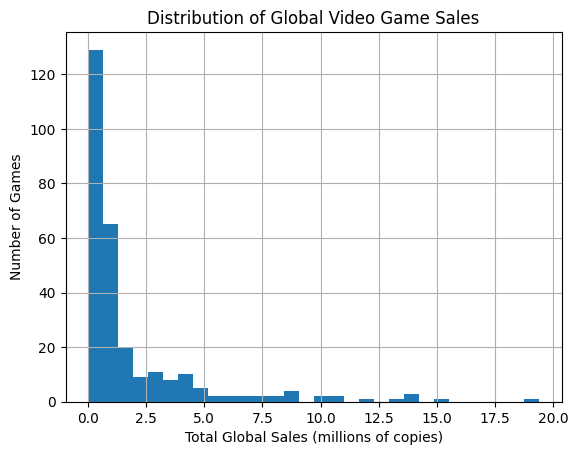

In [7]:
# Histogram of total (global) sales
plt.figure()
df['total_sales'].hist(bins=30)
plt.xlabel('Total Global Sales (millions of copies)')
plt.ylabel('Number of Games')
plt.title('Distribution of Global Video Game Sales')
plt.show()

## Initial Display of Average Sales to Potential Features

The following three bar graphs show how game genres, publishers, platform, and developers affect the average game sales. Pre-testing, the data proves to be rather indicative already of some potentially high-importance features.

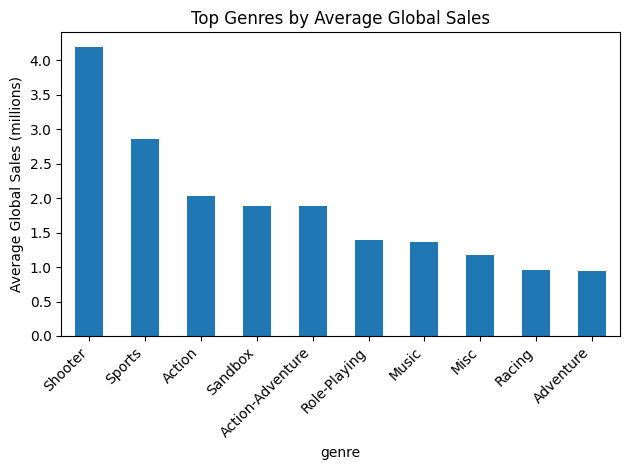

In [8]:
# Top 10 genres by average global sales
plt.figure()
df.groupby('genre')['total_sales'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Average Global Sales (millions)')
plt.title('Top Genres by Average Global Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

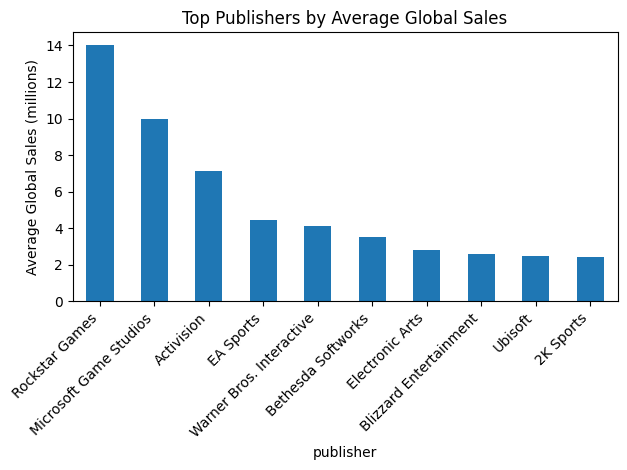

In [22]:
# Top publishers by average global sales
plt.figure()
df.groupby('publisher')['total_sales'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Average Global Sales (millions)')
plt.title('Top Publishers by Average Global Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

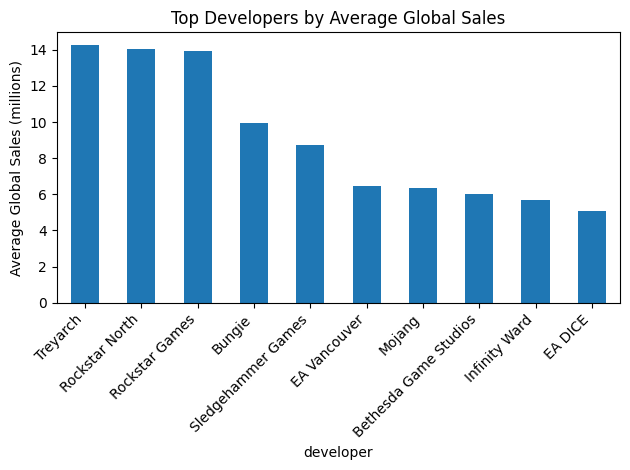

In [23]:
# Top developers by average global sales
plt.figure()
df.groupby('developer')['total_sales'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Average Global Sales (millions)')
plt.title('Top Developers by Average Global Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

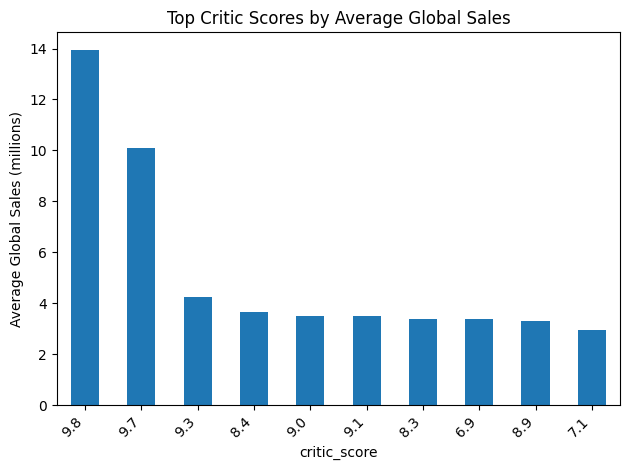

In [24]:
# Top average critic scores by average global sales
plt.figure()
df.groupby('critic_score')['total_sales'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Average Global Sales (millions)')
plt.title('Top Critic Scores by Average Global Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

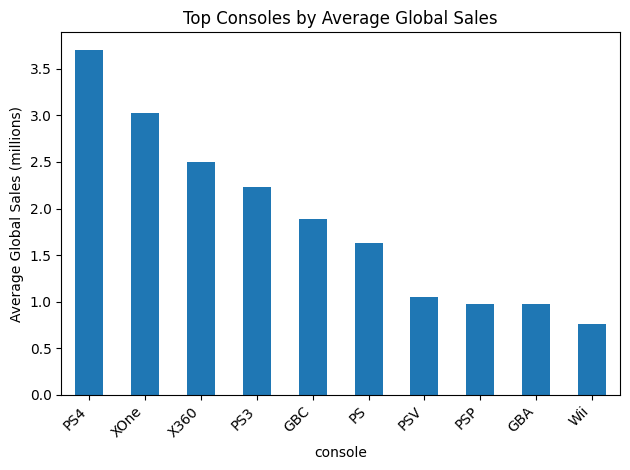

In [25]:
# Top platforms by average global sales
plt.figure()
df.groupby('console')['total_sales'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Average Global Sales (millions)')
plt.title('Top Consoles by Average Global Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Feature Selection and Preprocessing

We will:
- Choose **total_sales** as the target (what we want to predict).
- Use the remaining columns as input features.
- Handle categorical features (like genre, platform, publisher) using **One-Hot Encoding**.

We let scikit-learn's ColumnTransformer and Pipeline handle all preprocessing cleanly.

In [9]:
# Define target and features
target_column = 'total_sales'
X = df.drop(columns=[
    'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales'
])
y = df['total_sales']

# Identify categorical vs numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print('Categorical columns:', categorical_cols)
print('Numeric columns:', numeric_cols)

Categorical columns: ['img', 'title', 'console', 'genre', 'publisher', 'developer', 'release_date', 'last_update']
Numeric columns: ['critic_score']


### Build the Preprocessing + Model Pipeline

Steps:
1. Apply **OneHotEncoder** to categorical features.
2. Pass numeric features through unchanged.
3. Feed the transformed features into a **RandomForestRegressor**.

Wrapping everything in a Pipeline ensures that all preprocessing happens automatically during training and prediction.

In [10]:
# Preprocess categorical features with one-hot encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# Define the Random Forest Regressor model
rf_model = RandomForestRegressor(
    n_estimators=200,       # number of trees in the forest
    max_depth=None,         # let trees grow until all leaves are pure or contain <2 samples
    random_state=0,         # can be anything tbh, this doesn't really matter
    n_jobs=-1               # use all CPU cores available. faster processing (so I was informed)
)

# Full pipeline: preprocessing + model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

print('Pipeline created successfully!')

Pipeline created successfully!


## Train/Test Split and Model Training

We split the data into:
- **Training set** (80%) – used to fit the model.
- **Test set** (20%) – used to see how well the model generalizes.

In [11]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

# Fit the pipeline on the training data
model.fit(X_train, y_train)
print('Model training completed!')

Train shape: (225, 9)
Test shape: (57, 9)
Model training completed!


## Model Evaluation

We evaluate the model using:
- **R² Score**: how much variance in the target is explained by the model (1.0 is perfect).
- **RMSE (Root Mean Squared Error)**: average prediction error in the same units as the target.

In [16]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute R^2 score
r2 = r2_score(y_test, y_pred)

# Compute RMSE
rmse = mean_squared_error(y_test, y_pred)

print(f'R^2 score on test set: {r2:.4f}')
print(f'RMSE on test set: {rmse:.4f} (millions of copies sold globally)')

R^2 score on test set: 0.4182
RMSE on test set: 5.1100 (millions of copies sold globally)


## Feature Importance

Random Forest gives us a measure of **feature importance**.
Because we used one-hot encoding, one original categorical feature (e.g., genre) becomes multiple binary columns (e.g., genre_Action, genre_Sports, etc.).

We will:
1. Extract the trained RandomForest model.
2. Get feature names from the ColumnTransformer.
3. Display and plot the top features influencing global sales.

In [13]:
# Access the trained RandomForestRegressor and the preprocessor
rf = model.named_steps['model']
ohe = model.named_steps['preprocessor'].named_transformers_['cat']

# Get names for the one-hot encoded categorical features
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

# Combine them with numeric feature names (which passed through unchanged)
all_feature_names = list(ohe_feature_names) + numeric_cols

importances = rf.feature_importances_

# Put into a DataFrame for easier viewing
feat_imp = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(20)

,feature,importance
590,developer_Treyarch,0.158765
469,publisher_Rockstar Games,0.121040
445,publisher_Activision,0.107236
881,critic_score,0.089462
805,last_update_2018-03-24,0.043291
120,img_/games/boxart/full_5257064AmericaFrontccc.jpg,0.042158
438,genre_Shooter,0.028367
417,console_PS4,0.026026
491,developer_Bethesda Game Studios,0.024849
594,developer_Ubisoft Montreal,0.022278


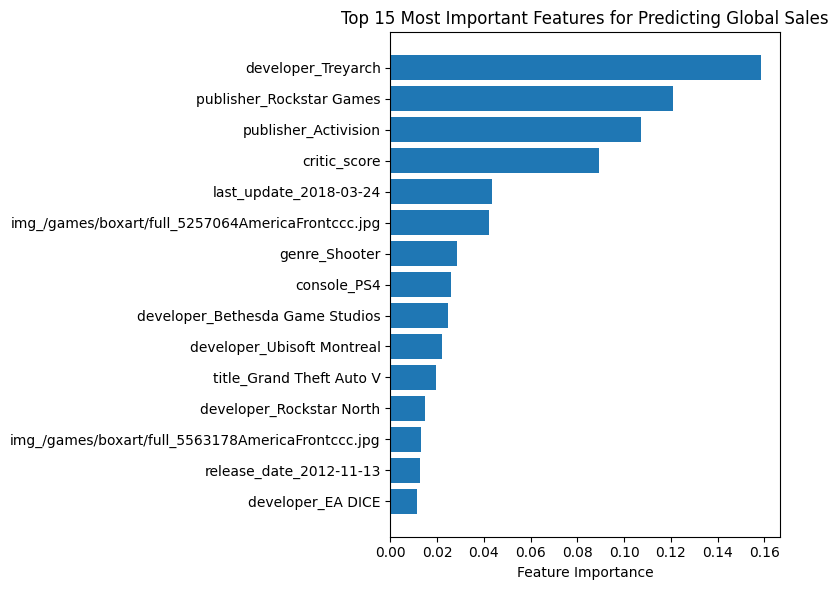

In [14]:
# Plot the top 15 most important features
top_n = 15
top_features = feat_imp.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Most Important Features for Predicting Global Sales')
plt.tight_layout()
plt.show()

## What we learned

From the training of the model, we found that the largest 3 overarching drivers of videogame sales were the development team, the publishers (aka marketing), and the critic score.
This gives insight, leading credence to the fact that developer trust and renown (Treyarch is a popular gamedev studio due to over a decade of yearly consistently successful game releases) , marketing rigor, and positive early critic rating lead to a higher average of sales (The more people with early access to the game speak highly of it, the more people will be incentivised to buy the game).
However, due to how the read data was organized, the R^2 appears low in indication to the testing fit, but the importance can be easily discerned from the top-most important features.


## Summary

In this notebook, we:
- Loaded a cleaned video game sales dataset.
- Explored the data and visualized basic patterns.
- Built a preprocessing + Random Forest regression pipeline.
- Evaluated the model with R² and RMSE.
- Inspected feature importances to understand which factors most influence sales.

This directly supports the project goal of predicting global video game sales and understanding key drivers using machine learning.